In [2]:
import numpy as np
import os
import pandas as pd
from pprint import pprint
import pickle as pkl
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pb = np.load("/home/hengfei/Desktop/research/D-NeRF/data/subject0000/poses_bounds.npy")
loop_num = 20
pb = np.tile(pb, (loop_num, 1))
pb_gaze = np.zeros((14*loop_num, 19))
pb_gaze[:, :17] = pb
cam_list = [0, 1 ,2 ,3, 4, 5, 6, 7, 8, 9, 10, 13, 16, 17]

base_dir = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000"
frames_list = sorted(os.listdir(base_dir))

csvPath = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000/subject0000.csv"
df = pd.read_csv(csvPath, header=None)

imgs_list = []
multi_views = True

for i in range(pb_gaze.shape[0]):
    if not multi_views:
        pb_cam = pb_gaze[i]
        frame = frames_list[i]
        cam_num = i % 14
        cam_num = cam_list[cam_num]
        cam = f"cam{str(cam_num).zfill(2)}.JPG"
        series = df[(df[0] == frame) & (df[1] == cam)].squeeze()
        gaze_code = np.array(series[2:4]/1000, dtype=float)
        pb_gaze[i, -2:] = gaze_code

        img = f"cam{str(cam_num).zfill(2)}_masked.png"
        img_path = os.path.join(base_dir, frame, img)
        imgs_list.append(img_path)
    else:
        pb_cam = pb_gaze[i]
        frame_num = i // 14
        frame = frames_list[frame_num]
        cam_num = i % 14
        cam_num = cam_list[cam_num]
        cam = f"cam{str(cam_num).zfill(2)}.JPG"
        series = df[(df[0] == frame) & (df[1] == cam)].squeeze()
        gaze_code = np.array(series[2:4]/1000, dtype=float)
        pb_gaze[i, -2:] = gaze_code

        img = f"cam{str(cam_num).zfill(2)}_masked.png"
        img_path = os.path.join(base_dir, frame, img)
        imgs_list.append(img_path)
        

train_set = {"pb": pb_gaze, "imgs": imgs_list}
if not multi_views:
    with open(f"{base_dir}/train_set.pkl", "wb") as f:
        pkl.dump(train_set, f)
else:
    with open(f"{base_dir}/train_set_multi_views.pkl", "wb") as f:
        pkl.dump(train_set, f)



In [8]:
with open(f"{base_dir}/train_set_multi_views.pkl", "rb") as f:
    train_data = pkl.load(f)

# pprint(train_data["imgs"])
pprint(train_data["pb"])

array([[-1.20045262e-03,  9.95745972e-01, -9.21331570e-02, ...,
         1.11525165e+01,  9.19000000e-01,  4.54000000e-01],
       [-1.19007883e-03,  9.51062751e-01, -3.08995514e-01, ...,
         6.82967414e+00,  9.19000000e-01,  4.54000000e-01],
       [-5.56092163e-03,  7.36735134e-01, -6.76158575e-01, ...,
         7.91591193e+00,  9.19000000e-01,  4.54000000e-01],
       ...,
       [ 6.38469177e-02,  9.91711629e-01, -1.11497158e-01, ...,
         8.30062711e+00,  6.87000000e-01,  2.76000000e-01],
       [ 2.39825616e-01,  9.28839821e-01,  2.82383182e-01, ...,
         7.28724068e+00,  6.87000000e-01,  2.76000000e-01],
       [-1.07318585e-01,  9.84663561e-01, -1.37551419e-01, ...,
         7.70430126e+00,  6.87000000e-01,  2.76000000e-01]])


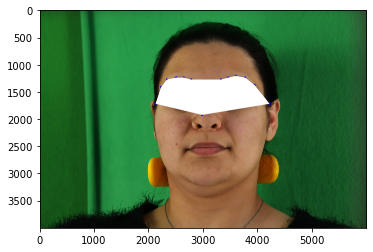

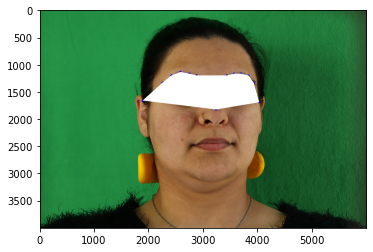

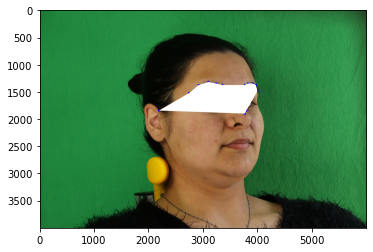

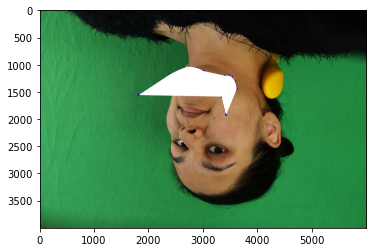

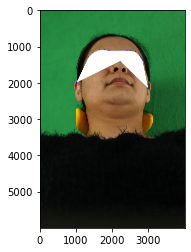

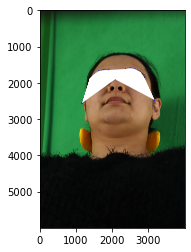

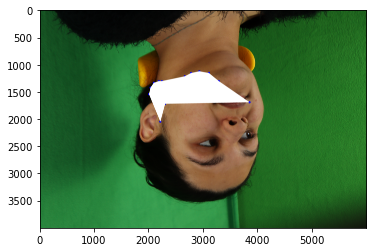

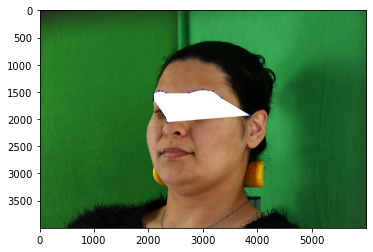

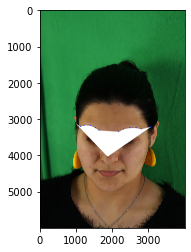

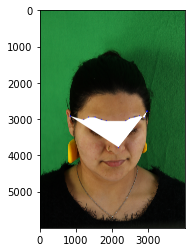

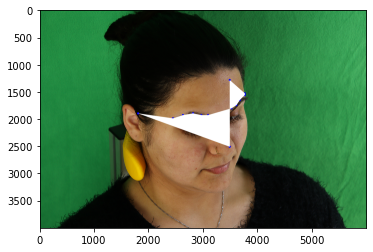

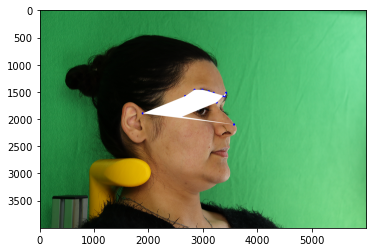

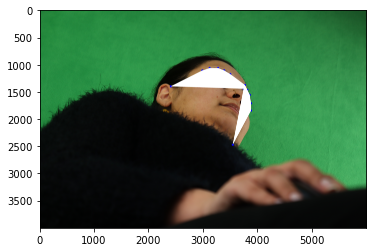

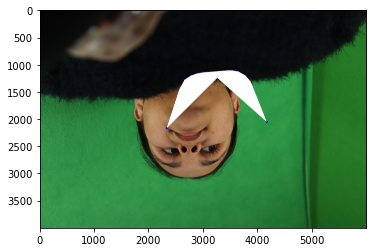

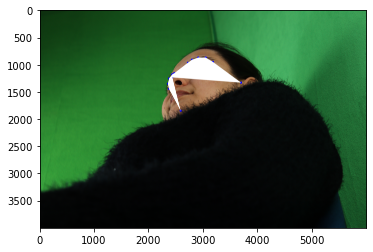

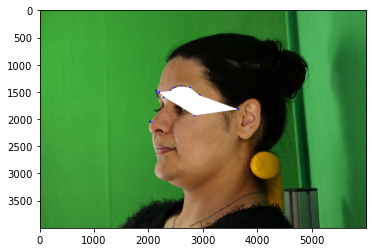

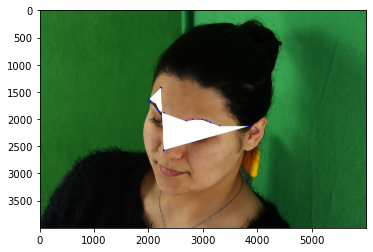

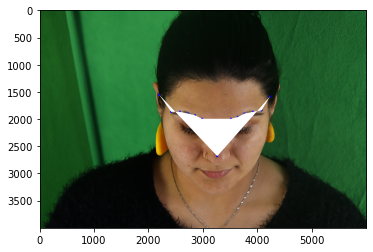

In [4]:
# check face landmarks in xgaze
csvPath = "/home/hengfei/Desktop/research/D-NeRF/data/subject0000/subject0000.csv"
df = pd.read_csv(csvPath, header=None)

imgs_num = [i for i in range(18)]

for img_num in imgs_num:
    landmarks = df.iloc[img_num,13:]
    landmarks = landmarks.to_numpy()

    img_path = f"/home/hengfei/Desktop/research/datasets/subject0000/frame0000/cam{str(img_num).zfill(2)}.JPG"
    img = cv2.imread(img_path)
    # contour_num = [17,18,19,20,21,22,23,24,25,26,16,15,29,1,0]
    # contour_num = [0,17,18,19,20,21,22,23,24,25,26,16,29]
    keypoint_num = [17,18,19,20,21,22,23,24,25,26,29]
    contour_num = [0,17,18,19,20,21,22,23,24,25,26,16,29]
    contour = []
    for i in contour_num:
        cv2.circle(img, (int(landmarks[i*2]), int(landmarks[i*2+1])), 20, (255,0,0), -1)
        if i in contour_num:
            if i == 99:
                keypoint = [(landmarks[i*2]+landmarks[45*2])/2, (landmarks[i*2+1]+landmarks[45*2+1])/2]
            elif i == 15:
                keypoint = [(landmarks[i*2]+landmarks[29*2])/2, (landmarks[i*2+1]+landmarks[29*2+1])/2]
            # elif i == 0:
            #     keypoint = [(landmarks[i*2]+landmarks[36*2])/2, (landmarks[i*2+1]+landmarks[36*2+1])/2]
            elif i == 1:
                keypoint = [(landmarks[i*2]+landmarks[29*2])/2, (landmarks[i*2+1]+landmarks[29*2+1])/2]
            else:
                keypoint = [landmarks[i*2], landmarks[i*2+1]]
            contour.append(keypoint)

    contour = np.array(contour, dtype=np.int32)
    cv2.fillPoly(img, [contour], (255,255,255))
    img = img[:,:,::-1]
    plt.imshow(img)
    plt.show()